# Bound from large deviations on feedback stochastic networks

### Retrieving the Poisson square

In [1]:
import graphviz
import pydot
import scipy

#import pydotplus #need of this only on University computer

from numpy import linalg as LA
import pandas as pd
from scipy.sparse.linalg import eigs
import statistics
import random as rnd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import tqdm
import math
import copy
import csv
import os
import sys
import json
import seaborn as sns
from tqdm import tqdm
sns.set_context('paper')
#sns.set_palette("")

#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib.font_manager import FontProperties as FP
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('font', family='serif')

np.set_printoptions(threshold=sys.maxsize)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cm = 1.0/2.54

full_marker = ['.','o','s','v','h','^','p','>','1','2','3','*']

font_scale = FP().copy()
font_scale.set_style('normal')
font_scale.set_weight('semibold')
font_scale.set_size(12)

font_legend = FP().copy()
font_legend.set_style('normal')
font_legend.set_weight('bold')
font_legend.set_size(8)

font_text = FP().copy()
font_text.set_style('normal')
font_text.set_weight('bold')
font_text.set_size(10)

font_legend_r = FP().copy()
font_legend_r.set_style('normal')
font_legend_r.set_weight('bold')
font_legend_r.set_size(11)

font_text_r = FP().copy()
font_text_r.set_style('normal')
font_text_r.set_weight('bold')
font_text_r.set_size(13)

font_text_r_new = FP().copy()
font_text_r_new.set_style('normal')
font_text_r_new.set_weight('bold')
font_text_r_new.set_size(18)

## Setting up the system (continuous-time RW over 2D lattice)

In [3]:
def f(j,ind):
    if(ind==0):
        return k1
    else:
        return ((j - (N-1)/2.) ** 2)

def g(i,ind):
    if(ind==0):
        return k2
    else:
        return ((i - (N-1)/2.) ** 2)
        
def Cij(i,j,tau1,tau2,ind):
    return i/tau1 + j/tau2 + g(i,ind) + f(j,ind)

def IndexMapLattice(i,j): 
    #the way to count is from left to right starting from the bottom row of the lattice
    return N*j+i

def IndexMapLatticeReverse(ij):
    return ij % N,int(ij/(N*1.))

def l1norm(vec):
    sumvec = sum(vec)
    return vec/sum(vec)

In [4]:
N = 5 #lattice sites (N*N)
ind = 0 #index determines the functions to be used in the feedback
tau1 = 1.
tau2 = 1.
k1 = 2.
k2 = 1.

In [5]:
#Building the transition matrix of the random walk over the lattice (transitions are possible only over NNs)
## i runs horizontally and j vertically in the 2D lattice
Pi = [[0 for lm in range(N*N)] for ij in range(N*N)]

for i in range(N):
    for j in range(N):
        ij = IndexMapLattice(i,j)
        #print(i,j,ij)
        if(j <= N-2):
            Pi[ij][ij+N] = g(i,ind)
        if(j >= 1):
            Pi[ij][ij-N] = j/tau2
        if(i <= N-2):
            Pi[ij][ij+1] = f(j,ind)
        if(i >= 1):
            Pi[ij][ij-1] = i/tau1
            
##Setting the diagonal as the negative sum of the row rates 
for ij in range(N*N):
    for lm in range(N*N):
        if(ij==lm):
            Pi[ij][lm] = - sum(Pi[ij])

## Simulations

In [6]:
# We need to simulate the random walk many times to extract the sample variance of the process (using Gillepsie)

def gillespie_2d_random_walk(transition_matrix, N, max_time):
    # Initialise the time, position, and trajectory
    t = 0
    current_state = (0, 0)
    trajectory = [(t, current_state)]

    while t < max_time:
        # Get the rates of transitions from the current state
        i, j = current_state
        row = j * N + i
        rates = [transition_matrix[row][i] for i in range(N*N)]
        #print(rates)
        rates[row] = 0
        #print(rates)
        #print(transition_matrix)
        escape_rate = -transition_matrix[row][row] #total escape rate given by minus diagonal term
        #print(escape_rate)
        
        # Generate two random numbers for time and transition
        dt = -np.log(rnd.random()) / escape_rate
        chosen_transition = np.random.choice(N*N, p=np.asarray(rates)/(escape_rate*1.))

        # Update time and current state
        t += dt
        current_state = (chosen_transition % N, chosen_transition // N)

        # Append to trajectory
        trajectory.append((t, current_state))

    return trajectory

stationary distribution
 [[0.052747252747252706, 0.10549450549450529, 0.10549450549450559, 0.07032967032967032, 0.03516483516483511], [0.05274725274725273, 0.10549450549450547, 0.10549450549450558, 0.07032967032967037, 0.03516483516483515], [0.02637362637362639, 0.052747252747252796, 0.05274725274725279, 0.03516483516483522, 0.017582417582417534], [0.008791208791208798, 0.017582417582417603, 0.017582417582417593, 0.011721611721611753, 0.005860805860805853], [0.0021978021978021956, 0.004395604395604399, 0.0043956043956044095, 0.002930402930402908, 0.001465201465201473]]


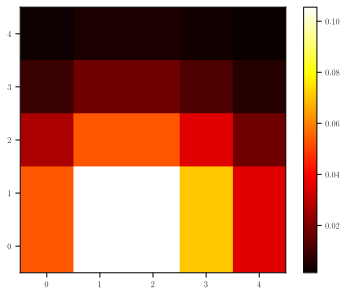

ergodic average
 [1.80952381 0.98461538]


In [7]:
#Stationary distribution of Pi (simply its left eigenvector)

eigenvalues, eigenvectors = LA.eig(np.transpose(Pi))
for i in range(N):
    if(eigenvalues[i]<=1e-10 and eigenvalues[i]>=-1e-10):
        dom = i
        break
        
domeigl1 = l1norm(np.real(eigenvectors[:,dom]))
#print(domeigl1)
#print(domeigl1)
statdistr = [[0 for j in range(N)] for i in range(N)]
for ij in range(N*N):
        i,j = IndexMapLatticeReverse(ij)
        statdistr[j][i] = domeigl1[ij]
print("stationary distribution\n", statdistr)

heatmap = plt.imshow(statdistr, cmap='hot', interpolation='nearest',origin='lower')
plt.colorbar(heatmap)
plt.show()

ergodicaverage = (0,0)
for i in range(N):
    for j in range(N):
        ergodicaverage += statdistr[j][i]*np.asarray((i,j))
print("ergodic average\n",ergodicaverage)

## Theory Sect. V - bound on variance from large deviations

In [11]:
def Cijfun(i,j):
    return i/(tau1*1.) + j/(tau2*1.) + g(i,ind) + f(j,ind)

def avC(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += stat[j][i]/(Cijfun(i,j))
    return temp
            
def aviC(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += i*stat[j][i]/(Cijfun(i,j))
    return temp

def avjC(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += j*stat[j][i]/(Cijfun(i,j))
    return temp
            
def avi2C(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += (i**2)*stat[j][i]/Cijfun(i,j)
    return temp
            
def avijC(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += i*j*stat[j][i]/Cijfun(i,j)
    return temp

def avj2C(stat,N):
    temp = 0
    for i in range(N):
        for j in range(N):
            temp += (j**2)*stat[j][i]/Cijfun(i,j)
    return temp

def Gamma(stat,N):
    a = avC(stat,N)
    b = aviC(stat,N)
    c = avjC(stat,N)
    d = avi2C(stat,N)
    e = avijC(stat,N)
    f = avj2C(stat,N)
    gam = - np.asarray([[a,b,c],[b,d,e],[c,e,f]])
    return gam

## Theory Sect. VII - bound on variance from large deviations

In [12]:
def C0ijfun(i,j):
    return i/(tau1*1.) + j/(tau2*1.) + k1 + k2

def lambdatilde(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += statdistr[j][i]/C0ijfun(i,j)
    return temp
            
def lambda1(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += i*statdistr[j][i]/C0ijfun(i,j)
    return temp
            
def lambda2(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += j*statdistr[j][i]/C0ijfun(i,j)
    return temp
            
def lambda11(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += i*i*statdistr[j][i]/C0ijfun(i,j)
    return temp

def lambda12(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += i*j*statdistr[j][i]/C0ijfun(i,j)
    return temp
            
def lambda22(statdistr):
    temp = 0
    for j in range(N):
        for i in range(N):
            temp += j*j*statdistr[j][i]/C0ijfun(i,j)
    return temp
            
def Lambda(a,b):
    if(a==0 and b==0):
        return lambda1(statdistr)**2/lambdatilde(statdistr) - lambda11(statdistr)
    elif(a==1 and b==1):
        return lambda2(statdistr)**2/lambdatilde(statdistr) - lambda22(statdistr)
    else:
        return lambda1(statdistr)*lambda2(statdistr)/lambdatilde(statdistr) - lambda12(statdistr)

def LambdaInv(a,b):
    det = Lambda(0,0)*Lambda(1,1) - Lambda(0,1)*Lambda(1,0)
    if(a==0 and b==0):
        return (1./det)*Lambda(1,1)
    elif(a==1 and b==1):
        return (1./det)*Lambda(0,0)
    else:
        return -(1./det)*Lambda(1,0)
    
def CovMatrix(x1,x2,statdistr):
    if(x1==0 and x2==0):
        temp = 0
        for j in range(N):
            for i in range(N):
                temp += (statdistr[j][i]/(C0ijfun(i,j)))*(LambdaInv(0,0)*(i-lambda1(statdistr)/lambdatilde(statdistr))+LambdaInv(0,1)*(j-lambda2(statdistr)/lambdatilde(statdistr)))**2
        return 1./temp
    elif(x1==1 and x2==1):
        temp = 0
        for j in range(N):
            for i in range(N):
                temp += (statdistr[j][i]/(C0ijfun(i,j)))*(LambdaInv(1,1)*(j-lambda2(statdistr)/lambdatilde(statdistr))+LambdaInv(0,1)*(i-lambda1(statdistr)/lambdatilde(statdistr)))**2
        return 1./temp
    else:
        temp = 0
        for j in range(N):
            for i in range(N):
                temp += 2*(statdistr[j][i]/(C0ijfun(i,j)))*(LambdaInv(0,0)*(i-lambda1(statdistr)/lambdatilde(statdistr))+LambdaInv(0,1)*(j-lambda2(statdistr)/lambdatilde(statdistr)))*(LambdaInv(0,1)*(i-lambda1(statdistr)/lambdatilde(statdistr))+LambdaInv(1,1)*(j-lambda2(statdistr)/lambdatilde(statdistr)))
        return 1./temp

## Results

### From simulations

In [14]:
# Simulate the random walk
max_time = 1000  # Maximum time for simulation
max_sim_num = 100

# Print the trajectory
#for t, state in trajectory:
#    print(f"Time: {t}, State: {state}")

#Sample mean trajectory
trajectory = gillespie_2d_random_walk(Pi, N, max_time)

samplemean = (0,0)
for i in range(len(trajectory)-1):
    samplemean += (trajectory[i+1][0]-trajectory[i][0])*np.asarray(trajectory[i][1])
samplemean = samplemean/max_time

#Sample asymptotic variance from many simulations
samplevariance = (0,0)
samplemean_list = list()
for i in tqdm(range(max_sim_num)):
    trajectory = gillespie_2d_random_walk(Pi, N, max_time)
    samplemeantemp = (0,0)
    for i in range(len(trajectory)-1):
        samplemeantemp += (trajectory[i+1][0]-trajectory[i][0])*np.asarray(trajectory[i][1])
    samplemeantemp = samplemeantemp/max_time
    samplemean_list.append(samplemeantemp)
    samplevariance += (samplemeantemp-np.asarray(ergodicaverage))**2
samplevariance = samplevariance/max_sim_num

100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


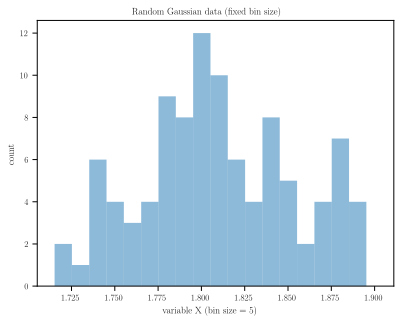

In [11]:
data = np.transpose(samplemean_list)[1]

bins = np.arange(min(data), max(data), 0.01) # fixed bin size

plt.xlim([min(data)-0.01, max(data)+0.01])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [15]:
samplemean

array([3.29861079, 1.73937486])

In [13]:
## This is not the asymptotic variance!
samplevariance

array([0.0004359 , 0.00198987])

### Bound from theory (Sect. V)

In [17]:
GammaInv = LA.inv(Gamma(statdistr,N))

H11 = - GammaInv[1][1]
H22 = - GammaInv[2][2]
H12 = - Gamma(statdistr,N)[0][0]*GammaInv[0][1]*GammaInv[0][2]
H21 = - Gamma(statdistr,N)[0][0]*GammaInv[0][1]*GammaInv[0][2]

H = [[H11,H12],[H21,H22]]

#print(H)

In [25]:
CovMatrixFinalV = [[1./H11,1./(H12)],[1./(H12),1./H22]]

#print(CovMatrixFinalV)

#Cov(x1,x2) = Cov(x2,x1) (should divide them up by two to get the total covariance)

CovFinalV = [1./H11, 1./(2*H12) ,1./H22]

print(CovFinalV)

[0.058603401753814385, 0.0073469365897129045, 0.09817641582967579]


### Bound from theory (Sect. VII)

In [26]:
CovFinalVII = [CovMatrix(0,0,statdistr),CovMatrix(0,1,statdistr),CovMatrix(1,1,statdistr)]

print(CovFinalVII)

[0.05860340175381494, -6.459094881410559, 0.09817641582967601]


#### Suboptimal density

SubRho



Normalisation: 1.4051260155412137e-16
Perturbation: [0.09999999999999987, -5.898059818321144e-17] 

Stat Distr


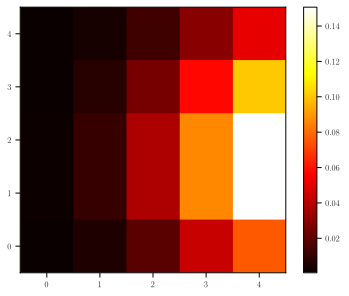

Stat Distr + SubRho


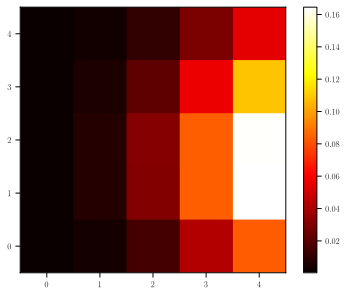

In [47]:
Subrho = [[0 for j in range(N)] for i in range(N)]
x1eps = 0.1
x2eps = 0.

for j in range(N):
    for i in range(N):
        Subrho[j][i] = - (statdistr[j][i]/C0ijfun(i,j))*((i-lambda1(statdistr)/lambdatilde(statdistr))*
                            (LambdaInv(0,0)*x1eps+LambdaInv(0,1)*x2eps) + (j-lambda2(statdistr)/lambdatilde(statdistr))*
                                (LambdaInv(0,1)*x1eps+LambdaInv(1,1)*x2eps))

print("SubRho\n")
heatmap = plt.imshow(Subrho, cmap='hot', interpolation='nearest',origin='lower')
plt.colorbar(heatmap)
plt.show()

#checks:

temp = 0
for j in range(N):
    for i in range(N):
        temp += Subrho[j][i]
        
print("Normalisation:", temp)

tempx1eps = 0.
tempx2eps = 0.
for j in range(N):
    for i in range(N):
        tempx1eps += Subrho[j][i]*i
        tempx2eps += Subrho[j][i]*j
        
print("Perturbation:", [tempx1eps,tempx2eps], "\n")
        
print("Stat Distr")

heatmap = plt.imshow(statdistr, cmap='hot', interpolation='nearest',origin='lower')
plt.colorbar(heatmap)
plt.show()

print("Stat Distr + SubRho")

heatmap = plt.imshow(list(np.asarray(statdistr)+np.asarray(Subrho)), cmap='hot', interpolation='nearest',origin='lower')
plt.colorbar(heatmap)
plt.show()



### Calculating the exact asymptotic variance from tilted matrix

#### The values we get below for the asymptotic variance will have to be compared with the bounds above

In [27]:
deltas = 0.001
s1list = np.arange(-0.1,0.1,deltas)
s2list = np.arange(-0.1,0.1,deltas)

PiT = [[[[0 for lm in range(N*N)] for ij in range(N*N)] for s2ind in range(len(s2list))] for s1ind in range(len(s1list))]

for s1ind in range(len(s1list)):
    s1 = s1list[s1ind]
    for s2ind in range(len(s2list)):
        s2 = s2list[s2ind]
        for i in range(N):
            for j in range(N):
                ij = IndexMapLattice(i,j)
                #print(i,j,ij)
                if(j <= N-2):
                    PiT[s1ind][s2ind][ij][ij+N] = Pi[ij][ij+N]#*np.exp(s1*i+s2*(j+1))
                if(j >= 1):
                    PiT[s1ind][s2ind][ij][ij-N] = Pi[ij][ij-N]#*np.exp(s1*i+s2*(j-1))
                if(i <= N-2):
                    PiT[s1ind][s2ind][ij][ij+1] = Pi[ij][ij+1]#*np.exp(s1*(i+1)+s2*j)
                if(i >= 1):
                    PiT[s1ind][s2ind][ij][ij-1] = Pi[ij][ij-1]#*np.exp(s1*(i-1)+s2*j)

        for ij in range(N*N):
            for lm in range(N*N):
                if(ij==lm):
                    i,j = IndexMapLatticeReverse(ij)
                    PiT[s1ind][s2ind][ij][lm] = Pi[ij][lm]+s1*i+s2*j

In [28]:
scgf = [[0 for s2ind in range(len(s2list))] for s1ind in range(len(s1list))]
for s1ind in range(len(s1list)):
    s1 = s1list[s1ind]
    for s2ind in range(len(s2list)):
        s2 = s2list[s2ind]
        scgf[s1ind][s2ind] = max(LA.eigvals(PiT[s1ind][s2ind]))

In [30]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import SmoothBivariateSpline

data = np.array(scgf)
scgf_interp = RegularGridInterpolator((s1list, s2list), data)

def flatten(xss):
    return [x for xs in xss for x in xs]

scgf_flat = flatten(scgf)
s1list_conc = [[s1list[sind] for i in range(len(s1list))] for sind in range(len(s1list))]
s2list_conc = [[s2list[sind] for sind in range(len(s2list))] for i in range(len(s2list))]
s1list_flat = flatten(s1list_conc)
s2list_flat = flatten(s2list_conc)

scgf_interp_spline = SmoothBivariateSpline(s1list_flat, s2list_flat, scgf_flat, kx=4, ky=4)

In [19]:
plt.contour(s1list,s2list,scgf_interp_spline(s1list,s2list),3000)
plt.xlabel('s1')
plt.ylabel('s2')
plt.colorbar()
plt.show()

Locator attempting to generate 2548 ticks ([-0.49920000000000003, ..., 0.5196000000000001]), which exceeds Locator.MAXTICKS (1000).


In [20]:
plt.plot(s1list,scgf_interp_spline(s1list,0.))
plt.grid()
plt.xlabel('s1')
plt.show()

In [21]:
# The derivative gives back the ergodic average (which will have to match the sample mean obtained from simulations
# above)

plt.plot(s1list,scgf_interp_spline(s1list,0.,1,0))
plt.grid()
plt.xlabel('s1')
plt.show()

In [32]:
print("x1 ergodic average", scgf_interp_spline(0.,0.,1,0))

x1 ergodic average [[3.30858809]]


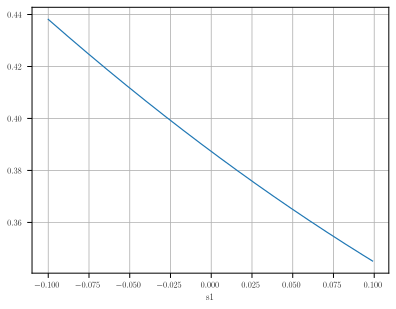

In [22]:
# The value that we read at 0 is the asymptotic variance of x1

plt.plot(s1list,scgf_interp_spline(s1list,0.,2,0))
plt.grid()
plt.xlabel('s1')
plt.show()

In [33]:
print("x1 asymptotic variance", scgf_interp_spline(0.,0.,2,0))

x1 asymptotic variance [[0.3873082]]


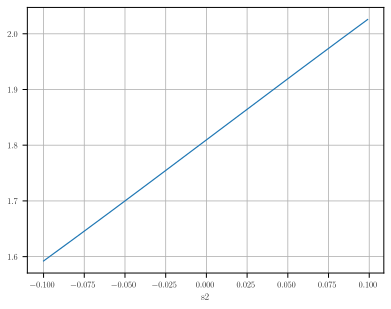

In [23]:
# The derivative gives back the ergodic average (which will have to match the sample mean obtained from simulations
# above)

plt.plot(s2list,scgf_interp_spline(0.,s2list,0,1)[0])
plt.grid()
plt.xlabel('s2')
plt.show()

In [34]:
print("x2 ergodic average", scgf_interp_spline(0.,0.,0,1))

x2 ergodic average [[1.80952383]]


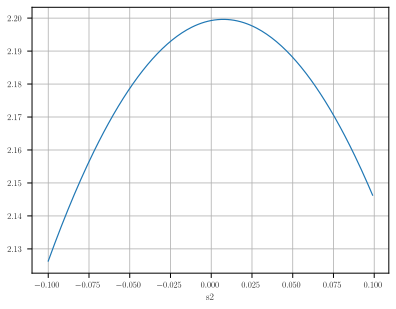

In [24]:
# The value that we read at 0 is the asymptotic variance of x2

plt.plot(s2list,scgf_interp_spline(0.,s2list,0,2)[0])
plt.grid()
plt.xlabel('s2')
plt.show()

In [35]:
print("x2 asymptotic variance", scgf_interp_spline(0.,0.,0,2))

x2 asymptotic variance [[2.19927587]]


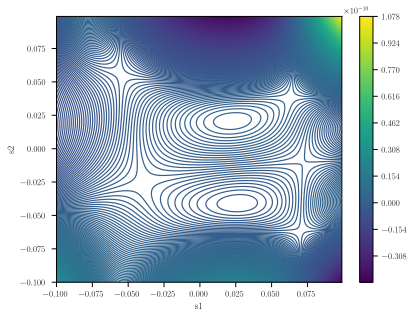

In [25]:
plt.contour(s1list,s2list,scgf_interp_spline(s1list,s2list,1,1),1000)
plt.xlabel('s1')
plt.ylabel('s2')
plt.colorbar()
plt.show()

## Perturbative optimal flux + Kirchoff law approach

In [8]:
## Given the stationary distribution and the form of the perturbed rates, the perturbed density is fully 
## determined by solving a linear system of equations.

### For feps and geps we use f and g and feed them with the index and ind=1 to get the perturbed rate

### We map states (i,j) into a single number. This simplifies the calculation as it allows to simply deal
### with matrices and vectors.

#Building the transition matrix of the random walk over the lattice (transitions are possible only over NNs)
## i runs horizontally and j vertically in the 2D lattice

A = [[0 for lm in range(N*N)] for ij in range(N*N)]

ind = 0

for i in range(N):
    for j in range(N):
        ij = IndexMapLattice(i,j)
        if(j <= N-2):
            A[ij][ij+N] = (j+1)/tau2
        if(j >= 1):
            A[ij][ij-N] = g(i,ind)
        if(i <= N-2):
            A[ij][ij+1] = (i+1)/tau1
        if(i >= 1):
            A[ij][ij-1] = f(j,ind)
            
c=0
##Setting the diagonal 
for ij in range(N*N):
    for lm in range(N*N):
        if(ij==lm):
            i,j = IndexMapLatticeReverse(ij)
            if(j!=0 and j!=N-1 and i!=0 and i!=N-1):
                c+=1
                A[ij][lm] = - (i/tau1 + j/tau2 + k2 + k1)
            elif(j==0):
                if(i<N-1):
                    c+=1
                    A[ij][lm] = - (i/tau1 + k1 + k2)
                else:
                    c+=1
                    A[ij][lm] = - (i/tau1 + k2)
            elif(j==N-1):
                if(i<N-1):
                    c+=1
                    A[ij][lm] = - (i/tau1 + j/tau2 + k1)
                else:
                    c+=1
                    A[ij][lm] = - (i/tau1 + j/tau2)
            elif(i==0):
                if(j>=1 and j<=N-2):
                    c+=1
                    A[ij][lm] = - (j/tau2 + k1 + k2)
            elif(i==N-1):
                if(j>=1 and j<=N-2):
                    c+=1
                    A[ij][lm] = - (i/tau1 + j/tau2 + k2)               

ind = 1
            
B = [[0 for lm in range(N*N)] for ij in range(N*N)]

for j in range(N):
    for i in range(N):
        ij = IndexMapLattice(i,j)
        if(j >= 1):
            B[ij][ij-N] = g(i,ind)
        if(i >= 1):
            B[ij][ij-1] = f(j,ind)
    
c=0
            
##Setting the diagonal 
for ij in range(N*N):
    for lm in range(N*N):
        if(ij==lm):
            i,j = IndexMapLatticeReverse(ij)
            if(j!=0 and j!=N-1 and i!=0 and i!=N-1):
                c+=1
                B[ij][lm] = -f(j,ind) - g(i,ind)
            elif(j==0):
                if(i<N-1):
                    c+=1
                    B[ij][lm] = -f(j,ind) - g(i,ind)
                else:
                    c+=1
                    B[ij][lm] = - g(i,ind)
            elif(j==N-1):
                if(i<N-1):
                    c+=1
                    B[ij][lm] = -f(j,ind)
                else:
                    c+=1
                    B[ij][lm] = 0
            elif(i==0):
                if(j>=1 and j<=N-2):
                    c+=1
                    B[ij][lm] = -f(j,ind) - g(i,ind)
            elif(i==N-1):
                if(j>=1 and j<=N-2):
                    c+=1
                    B[ij][lm] = - g(i,ind)

statdistrvec = [0 for ij in range(N*N)]

for i in range(N):
    for j in range(N):
        ij = IndexMapLattice(i,j)
        statdistrvec[ij] = statdistr[j][i]

In [9]:
PertDensityVec = np.linalg.solve(A, -np.asarray(B).dot(np.asanyarray(statdistrvec)))

In [10]:
PertDensity = [[0 for j in range(N)] for i in range(N)]

for ij in range(N*N):
    i,j = IndexMapLatticeReverse(ij)
    PertDensity[j][i] = PertDensityVec[ij]

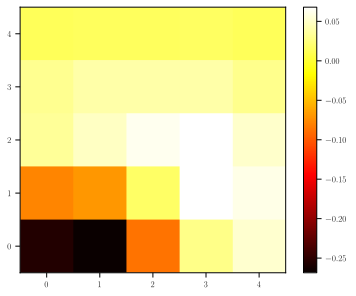

In [11]:
heatmap = plt.imshow(PertDensity, cmap='hot', interpolation='nearest',origin='lower')
plt.colorbar(heatmap)
plt.show()

In [14]:
np.sum(PertDensityVec)

-0.038333111639014435

In [16]:
np.linalg.eig(A)[0]

array([-1.49848387e+01, -1.25202661e+01, -1.16758903e-15, -1.18542706e+01,
       -1.04396726e+00, -1.24946478e+00, -1.07725830e+01, -2.29343204e+00,
       -2.33203131e+00, -3.00000000e+00, -9.38969795e+00, -9.54428703e+00,
       -9.48451892e+00, -3.58149609e+00, -4.04396726e+00, -4.07971440e+00,
       -8.44055166e+00, -7.64201487e+00, -7.79375181e+00, -7.07971440e+00,
       -6.35395082e+00, -6.54428703e+00, -5.30998356e+00, -5.32917917e+00,
       -5.33203131e+00])